## Figure 2 - Time Series Observations: Earthquake, GPS, InSAR

In [1]:
%matplotlib inline
import os
import numpy as np
from datetime import timedelta, datetime as dt
from matplotlib import pyplot as plt, ticker, dates as mdates
from mintpy.defaults.plot import *
from mintpy.objects.gps import *
from mintpy.utils import ptime, readfile, utils as ut, plot as pp

work_dir = os.path.expanduser('~/Papers/2020_Kirishima/figs_src/obs')
os.chdir(work_dir)
print('Go to directory', work_dir)

Go to directory /Users/yunjunz/Papers/2020_Kirishima/figs_src/obs


### Read time-series data

In [84]:
## Number of EQs
num_eq_file = os.path.expanduser('~/Papers/2020_Kirishima/figs_src/data/num_earthquake.csv')
fc = np.loadtxt(num_eq_file, delimiter=',', dtype=bytes).astype(str)
eq_dates = np.array([dt.strptime(i, '%Y-%m') for i in fc[:,0]])
# read number of EQs around Shinmoe-dake and Iwo-yama into eq_num_list
eq_num_list = []
for i in range(1, fc.shape[1]):
    eq_num = fc[:,i]
    eq_num[eq_num == ''] = '0'
    eq_num = eq_num.astype(np.float32)
    eq_num[eq_num == 0] = np.nan
    eq_num_list.append(eq_num)


## GPS baseline change
gps_dir = os.path.expanduser('~/data/Kirishima/GPS/GSI_F3')
t0, t1 = '20070101', '20191001'
site1, sites = '950486', '960714'
dates1, x1, y1, z1 = read_GSI_F3(gps_dir, '950486', t0, t1)
dates2, x2, y2, z2 = read_GSI_F3(gps_dir, '960714', t0, t1)
gps_dates, gps_lens = get_baseline_change(dates1, x1, y1, z1, dates2, x2, y2, z2)
## start from zero
#idx = gps_dates.index(dt(2005, 12, 15, 12, 0))
#gps_lens -= gps_lens[idx]

### Utilities Functions

In [176]:
## Utilities function for point time-series
def read_point_displacement_timeseries(ts_file, pts_lalo):
    dates, dis_ts = ut.read_timeseries_lalo(pts_lalo[0], pts_lalo[1], ts_file, unit='cm', print_msg=False)
    dis_ts -= dis_ts[0]
    ex_date_txt = os.path.join(os.path.dirname(ts_file), 'exclude_date.txt')
    ex_dates = ptime.date_list2vector(ptime.read_date_list(ex_date_txt))[0]
    idx_ex = [dates.tolist().index(di) for di in dates if di in ex_dates]
    idx_kp = [dates.tolist().index(di) for di in dates if di not in ex_dates]
    return dis_ts, dates, idx_kp, idx_ex

def plot_point_displacement_timeseries(ax, ts_file, pts_lalo, offset=0, marker='^', label=None):
    if marker == '^':
        ms = 3
    else:
        ms = 2.5
    dis_ts, dates, idx_kp, idx_ex = read_point_displacement_timeseries(ts_file, pts_lalo)
    ax.scatter(dates[idx_ex], dis_ts[idx_ex] + offset, marker=marker, edgecolor='k', facecolors='none', s=ms**3, linewidths=0.5)
    ax.scatter(dates[idx_kp], dis_ts[idx_kp] + offset, marker=marker, edgecolor='k', facecolors='k', s=ms**3, linewidths=0.5, label=label)
    pp.auto_adjust_xaxis_date(ax, dates, every_year=1, buffer_year=0.3)
    return ax

def plot_date_of_interest(axs, y1max=1, y2min=0):
    """Plot the date(s) of interest for Kirishima volcano"""
    kwargs = dict(linewidth=2, zorder=0, clip_on=False, alpha=0.3)

    # Phreatic eruptions in Shinmoe-dake
    kwargs.update(linestyle='--', color=pp.mplColors[0])
    axs[0].axvline(x   =dt(2008, 8, 22), ymax=y1max, **kwargs)
    axs[0].axvspan(xmin=dt(2010, 3, 31), xmax=dt(2010, 7, 10), ymax=y1max, **kwargs)
    
    # Magmatic eruptions in Shinmoe-dake
    kwargs.update(linestyle='--', color=pp.mplColors[1])
    axs[1].axvline(x   =dt(2017, 10, 11), ymax=y1max, **kwargs)
    axs[0].axvspan(xmin=dt(2011, 1 , 19), xmax=dt(2011, 9, 7 ), ymax=y1max, **kwargs)
    axs[1].axvspan(xmin=dt(2018, 3 , 1 ), xmax=dt(2018, 6, 27), ymax=y1max, **kwargs)
    
    # Phreatic eruptions in Iwo-yama
    kwargs.update(linestyle='-', color=pp.mplColors[0], alpha=0.8)
    axs[1].axvline(x=dt(2018, 4, 19), ymin=y2min, **kwargs)
    return


def cut_along_xaxis(axs, figsize=[7, 1], width_ratio=[4, 5], ax2s=None):
    """Cut and hide part of the plot along x-axis"""
    axs[0].set_xlim(dt(2007, 9,  7), dt(2011,  9, 7))   # 4 years
    axs[1].set_xlim(dt(2014, 11, 5), dt(2019, 11, 5))  # 5 years

    # hide the spines between two axis
    axs[0].spines['right'].set_visible(False)
    axs[1].spines['left'].set_visible(False)
    axs[0].yaxis.tick_left()
    if ax2s is None:
        axs[1].yaxis.tick_right()

    # hide the spines between two axis for ax2
    if ax2s is not None:
        ax2s[0].set_yticks([])
        ax2s[0].spines['right'].set_visible(False)
        ax2s[1].spines['left'].set_visible(False)
        # turn off yticks on the right
        #axs[1].yaxis.tick_left()

    # plot diagonal lines in axes coordinates
    dx = 0.008
    dy = dx * figsize[0] / figsize[1]
    kwargs = dict(transform=axs[0].transAxes, color='k', clip_on=False)
    axs[0].plot((1-dx, 1+dx), ( -dy,  +dy), **kwargs)
    axs[0].plot((1-dx, 1+dx), (1-dy, 1+dy), **kwargs)

    dx *= (width_ratio[0] / width_ratio[1])
    kwargs.update(transform=axs[1].transAxes)
    axs[1].plot(( -dx,  +dx), ( -dy,  +dy), **kwargs)
    axs[1].plot(( -dx,  +dx), (1-dy, 1+dy), **kwargs)
    return

width_ratio = [4, 5]
print('Utilities functions initiated.')

Utilities functions initiated.


### (a) - Number of earthquakes @ Shinmoe-dake and Iwo-yama

save figure to file /Users/yunjunz/Papers/2020_Kirishima/figs_src/obs/ts_eq.png


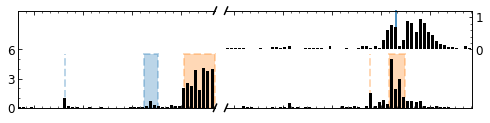

In [205]:
figsize = [7, 1.5]
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=figsize, sharey=True, gridspec_kw={'width_ratios': width_ratio})
ax2s = []
for ax in axs:
    #shift half a month to display the monthly average value in the center.
    ax.bar(eq_dates + timedelta(days=15), eq_num_list[0]/1000., width=22, color='k')
    ax.set_ylim(0, 10)

    ax2 = ax.twinx()
    ax2.bar(eq_dates + timedelta(days=15), eq_num_list[1]/1000., width=22, color='k')
    ax2.set_ylim(-1.8, 1.2)
    ax2s.append(ax2)

# Eruptive dates
plot_date_of_interest(axs, y1max=0.55, y2min=0.65)

# axes format
for ax in axs:
    #ax.tick_params(which='both', direction='in', labelsize=font_size, bottom=True, top=True, left=True, right=True)
    ax.xaxis.set_major_locator(mdates.YearLocator(1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.xaxis.set_minor_locator(mdates.MonthLocator(interval=2))
    ax.set_xticklabels([])

axs[0].tick_params( which='both', direction='in', labelsize=font_size, bottom=True, top=True, left=True, right=False)
axs[1].tick_params( which='both', direction='in', labelsize=font_size, bottom=True, top=True, left=False, right=False)
ax2s[0].tick_params(which='both', direction='in', labelsize=font_size, bottom=True, top=True, left=False, right=False)
ax2s[1].tick_params(which='both', direction='in', labelsize=font_size, bottom=True, top=True, left=False, right=True)

axs[0].yaxis.set_major_locator( ticker.FixedLocator([0,3,6]))
axs[0].yaxis.set_minor_locator( ticker.FixedLocator(np.linspace(0,6,7)))
ax2s[1].yaxis.set_major_locator(ticker.FixedLocator([0,1]))
ax2s[1].yaxis.set_minor_locator(ticker.FixedLocator(np.linspace(0,1,6)))
fig.subplots_adjust(wspace=0.05, left=0.05, right=0.95, top=0.95, bottom=0.05)

# Cut along x-axis
cut_along_xaxis(axs, figsize=figsize, ax2s=ax2s)

# output
out_file = os.path.abspath('ts_eq.png')
plt.savefig(out_file, bbox_inches='tight', transparent=True, dpi=fig_dpi)
print('save figure to file', out_file)
plt.show()

save figure to file /Users/yunjunz/Papers/2020_Kirishima/figs_src/obs/ts_eq_Shinmoe.png


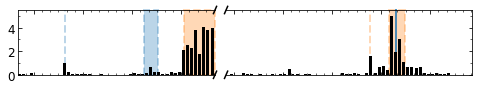

In [187]:
figsize = [7, 1]
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=figsize, sharey=True, gridspec_kw={'width_ratios': width_ratio})
for ax in axs:
    #shift half a month to display the monthly average value in the center.
    ax.bar(eq_dates + timedelta(days=15), eq_num_list[0]/1000., width=22, color='k') 

# Eruptive dates
plot_date_of_interest(axs)

# axes format
for ax in axs:
    ax.tick_params(which='both', direction='in', labelsize=font_size, bottom=True, top=True, left=True, right=True)
    ax.xaxis.set_major_locator(mdates.YearLocator(1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.xaxis.set_minor_locator(mdates.MonthLocator(interval=2))
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(2))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(2))
    ax.set_xticklabels([])
    ax.set_ylim(0,5.5)
fig.subplots_adjust(wspace=0.05, left=0.05, right=0.95, top=0.95, bottom=0.05)

# Cut along x-axis
cut_along_xaxis(axs, figsize=figsize)

# output
out_file = os.path.abspath('ts_eq_Shinmoe.png')
plt.savefig(out_file, bbox_inches='tight', transparent=True, dpi=fig_dpi)
print('save figure to file', out_file)
plt.show()

save figure to file /Users/yunjunz/Papers/2020_Kirishima/figs_src/obs/ts_eq_Iwo.png


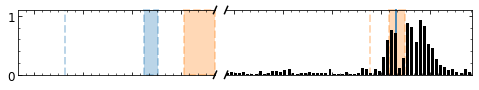

In [188]:
figsize = [7, 1]
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=figsize, sharey=True, gridspec_kw={'width_ratios': width_ratio})
for ax in axs:
    #shift half a month to display the monthly average value in the center.
    ax.bar(eq_dates + timedelta(days=15), eq_num_list[1]/1000., width=22, color='k') 

# Eruptive dates
plot_date_of_interest(axs)

# axes format
for ax in axs:
    ax.tick_params(which='both', direction='in', labelsize=font_size, bottom=True, top=True, left=True, right=True)
    ax.xaxis.set_major_locator(mdates.YearLocator(1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.xaxis.set_minor_locator(mdates.MonthLocator(interval=2))
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.set_xticklabels([])
    ax.set_ylim(0,1.1)
fig.subplots_adjust(wspace=0.05, left=0.05, right=0.95, top=0.95, bottom=0.05)

# Cut along x-axis
cut_along_xaxis(axs, figsize=figsize)

# output
out_file = os.path.abspath('ts_eq_Iwo.png')
plt.savefig(out_file, bbox_inches='tight', transparent=True, dpi=fig_dpi)
print('save figure to file', out_file)
plt.show()

### (b) GPS baseline change

save figure to file /Users/yunjunz/Papers/2020_Kirishima/figs_src/obs/ts_gps.png


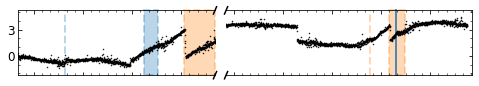

In [189]:
figsize = [7, 1]
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=figsize, sharey=True, gridspec_kw={'width_ratios': width_ratio})
for ax in axs:
    ax.scatter(gps_dates, gps_lens*100., marker='.', color='k', s=1**2)

# Eruptive dates
plot_date_of_interest(axs)

# axes format
for ax in axs:
    ax.tick_params(which='both', direction='in', labelsize=font_size, bottom=True, top=True, left=True, right=True)
    ax.xaxis.set_major_locator(mdates.YearLocator(1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.xaxis.set_minor_locator(mdates.MonthLocator(interval=2))
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(3))
    ax.set_xticklabels([])
    ax.set_ylim(-2.2, 5.2)
fig.subplots_adjust(wspace=0.05, left=0.05, right=0.95, top=0.95, bottom=0.05)

# Cut along x-axis
cut_along_xaxis(axs, figsize=figsize)

# output
out_file = os.path.abspath('ts_gps.png')
plt.savefig(out_file, bbox_inches='tight', transparent=True, dpi=fig_dpi)
print('save figure to file', out_file)
plt.show()

### (f) InSAR LOS displacement

save figure to file /Users/yunjunz/Papers/2020_Kirishima/figs_src/obs/ts_insar.png


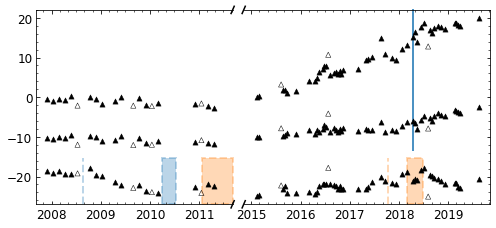

In [199]:
## Shinmoe-dake
ts_file1 = os.path.expanduser('~/data/Kirishima/KirishimaAlosDT73/mintpyAll/timeseries_ERA5_ramp_demErr.h5')
ts_file2 = os.path.expanduser('~/data/Kirishima/KirishimaAlos2DT23/mintpyAll/timeseries_ERA5_ramp_demErr.h5')

## Points of Interest
lalo_list = [
    [31.9131, 130.8867],  #POI for AlosDT73 at Shinmoe
    [31.9113, 130.8774],  #[31.9098, 130.8869],   #POI for Alos2DT23 at Shinmoe
    #[31.9467, 130.8524],  #POI for Alos2DT23 at Iwo for Alos2AT131
    [31.9465, 130.8531], #POI for Alos2DT23 at Iwo for Alos2DT23
    [31.9450, 130.8528],  #[31.9467, 130.8504], #POI for Alos2DT23 at Iwo for Alos2DT23 for post Dec 2017 expansion     
]

figsize = [7, 3]
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=figsize, sharey=True, gridspec_kw={'width_ratios': width_ratio})
#------ Displacement time-series
for ax in axs:
    # Shinmoe-dake
    plot_point_displacement_timeseries(ax, ts_file1, lalo_list[0], offset=-20)
    plot_point_displacement_timeseries(ax, ts_file2, lalo_list[1], offset=-25)
    # Iwo-yama crater
    plot_point_displacement_timeseries(ax, ts_file1, lalo_list[2], offset=0)
    plot_point_displacement_timeseries(ax, ts_file2, lalo_list[2], offset=0)
    # Iwo-yama south vent
    plot_point_displacement_timeseries(ax, ts_file1, lalo_list[3], offset=-10)
    plot_point_displacement_timeseries(ax, ts_file2, lalo_list[3], offset=-10)

#------ Eruptive dates
plot_date_of_interest(axs, y1max=0.24, y2min=0.28)

#------- axes format
for ax in axs:
    ax.tick_params(which='both', direction='in', labelsize=font_size, bottom=True, top=True, left=True, right=True)
    ax.set_ylim([-27, 22])
    ax.xaxis.set_major_locator(mdates.YearLocator(1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.xaxis.set_minor_locator(mdates.MonthLocator(interval=2))
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.yaxis.set_major_locator(ticker.MultipleLocator(10))
fig.subplots_adjust(wspace=0.05, left=0.05, right=0.95, top=0.95, bottom=0.05)

#----- Cut along x-axis
cut_along_xaxis(axs, figsize=figsize)

#----- output
out_file = os.path.abspath('ts_insar.png')
#plt.savefig(out_file, bbox_inches='tight', transparent=True, dpi=fig_dpi)
print('save figure to file', out_file)
plt.show()